## Loading the python packages

In [81]:
# Load libraries
import os
import alpaca_trade_api as tradeapi
import numpy as np
import pandas as pd
from datetime import datetime
from pandas_datareader import data

#import talib as ta

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [82]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the data

Next, we extract the data required for our analysis using pandas datareader. 

In [83]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [84]:
# Set the Tesla tickers
ticker = ["TSLA"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp("2013-01-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-08-01", tz="America/New_York").isoformat()

# Get 1 year's worth of historical data for Tesla and Coca-Cola
df_ticker = alpaca.get_barset(
    ticker,
    timeframe,
    start=start_date,
    end=end_date,
    limit=1000,
).df

# Display sample data
df_ticker.count()

TSLA  open      1000
      high      1000
      low       1000
      close     1000
      volume    1000
dtype: int64

In [85]:
# shape of the data
df_ticker.shape

(1000, 5)

## Data Preparation

In [104]:
stock_data = df_ticker.loc[:,'TSLA']
stock_data.head()

,open,high,low,close,volume
2017-08-10 00:00:00-04:00,362.00,366.6504,354.66,355.40,5778816
2017-08-11 00:00:00-04:00,356.97,361.2600,353.62,357.87,3447797
2017-08-14 00:00:00-04:00,364.63,367.6600,362.60,363.80,3538601
2017-08-15 00:00:00-04:00,365.20,365.4900,359.37,362.23,2333895
2017-08-16 00:00:00-04:00,363.00,366.5000,362.52,362.91,2514861


In [105]:
#Checking for null values and removing the null values if any
print('Null Values =',stock_data.isnull().values.any())

Null Values = False


In [106]:
# Create a short term moving average
stock_data['short_term_ma'] = stock_data['close'].rolling(window=10, min_periods=1).mean()

# Create a long term moving average
stock_data['long_term_ma'] = stock_data['close'].rolling(window=60, min_periods=1).mean()

# Create signal based on moving average cross over - this signal is the target (y var) to the classification models
stock_data['upside'] = np.where(stock_data['short_term_ma'] > stock_data['long_term_ma'], 1.0, 0.0)

In [107]:
stock_data[stock_data.upside == 1.0]

,open,high,low,close,volume,short_term_ma,long_term_ma,upside
2017-09-12 00:00:00-04:00,364.49,368.7600,360.4000,362.7100,4620028,352.59400,352.434348,1.0
2017-09-13 00:00:00-04:00,363.82,368.0700,359.5900,366.0601,3257417,354.47601,353.002088,1.0
2017-09-14 00:00:00-04:00,364.33,377.9600,362.6300,377.4400,5637380,356.90701,353.979604,1.0
2017-09-15 00:00:00-04:00,374.51,380.0000,372.7000,379.8100,4064278,359.29901,354.973081,1.0
2017-09-18 00:00:00-04:00,380.25,389.6100,377.6800,384.6100,5719442,362.23801,356.070744,1.0
...,...,...,...,...,...,...,...,...
2021-07-26 00:00:00-04:00,650.59,668.1999,647.1100,658.2899,21092626,652.98731,633.739637,1.0
2021-07-27 00:00:00-04:00,663.64,666.5000,627.2400,644.7800,31232379,650.57431,632.654470,1.0
2021-07-28 00:00:00-04:00,646.78,654.9699,639.4001,646.9700,14977027,649.93731,632.021803,1.0
2021-07-29 00:00:00-04:00,650.07,683.6900,648.8000,677.3600,28853702,652.58131,632.074803,1.0


## Feature Engineering

Our approach is based on price momentum. We will derive momentum fatures that will be used to predict future signals.

The current Data consists of date, open, high, low, close and volume. Following momentum indicatord are calculated using this data. 
* **Exponential Moving Average** : provides an indication of the overall trend of the price movement by smooting high volatility of the price movement.  
* **Stochastic Oscillator %K and %D** : a momentum indicator that compares a closing price to a range of its prices over a certain period of time. %K and %D are slow and fast indicators.
* **Relative Strength Index(RSI)** : a momentum indicator that measures the magnitude of recent price changes and indicates if the stock is overbought or oversold. 
* **Rate Of Change(ROC)**: a momentum oscillator that measures the percentage change between the current price and the n period past price. 
* **Momentum (MOM)** : measure the speed at which the price is changing.

In [108]:
#dunction to calculate moving average (MA)
def SMA(df, n):
    MA = pd.Series(df['close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA


#function to calculate exponential moving average (EMA)
def EMA(df, n):
    EMA = pd.Series(df['close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA


#funtion to calculate rate of change (ROC)
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC


#function to cacculate price momentum (MOM)
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM


#Function to caclulate relative strength index (RSI)
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)



#Function to calculate stochastic osillators - STOK: slow indicator and STOD: fast indicator.

def STOK(close, low, high, n): 
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

In [109]:
stock_data['EMA10'] = EMA(stock_data, 10)
stock_data['EMA30'] = EMA(stock_data, 30)
stock_data['EMA200'] = EMA(stock_data, 200)

In [110]:
stock_data['ROC10'] = ROC(stock_data['close'], 10)
stock_data['ROC30'] = ROC(stock_data['close'], 30)

In [111]:
stock_data['MOM10'] = MOM(stock_data['close'], 10)
stock_data['MOM30'] = MOM(stock_data['close'], 30)

In [112]:
stock_data['RSI10'] = RSI(stock_data['close'], 10)
stock_data['RSI30'] = RSI(stock_data['close'], 30)
stock_data['RSI200'] = RSI(stock_data['close'], 200)

In [113]:
stock_data['%D10'] = STOD(stock_data['close'], stock_data['low'], stock_data['high'], 10)
stock_data['%K30'] = STOK(stock_data['close'], stock_data['low'], stock_data['high'], 30)
stock_data['%D30'] = STOD(stock_data['close'], stock_data['low'], stock_data['high'], 30)
stock_data['%K200'] = STOK(stock_data['close'], stock_data['low'], stock_data['high'], 200)
stock_data['%D200'] = STOD(stock_data['close'], stock_data['low'], stock_data['high'], 200)

In [114]:
stock_data['MA10'] = SMA(stock_data, 10)
stock_data['MA30'] = SMA(stock_data, 30)
stock_data['MA200'] = SMA(stock_data, 200)

In [115]:
stock_data.tail()

,open,high,low,close,volume,short_term_ma,long_term_ma,upside,EMA10,EMA30,...,RSI30,RSI200,%D10,%K30,%D30,%K200,%D200,MA10,MA30,MA200
2021-07-26 00:00:00-04:00,650.59,668.1999,647.1100,658.2899,21092626,652.98731,633.739637,1.0,653.788824,650.339195,...,51.078962,49.962878,40.219984,60.835587,53.281095,53.555583,52.012194,652.98731,651.662103,643.791264
2021-07-27 00:00:00-04:00,663.64,666.5000,627.2400,644.7800,31232379,650.57431,632.654470,1.0,652.150856,649.980537,...,49.216919,49.811796,40.992631,48.150235,51.921721,50.963955,51.734473,650.57431,652.565103,644.885564
2021-07-28 00:00:00-04:00,646.78,654.9699,639.4001,646.9700,14977027,649.93731,632.021803,1.0,651.208882,649.786309,...,49.525475,49.836509,49.039887,50.206573,53.064131,51.384066,51.967868,649.93731,654.157437,645.950614
2021-07-29 00:00:00-04:00,650.07,683.6900,648.8000,677.3600,28853702,652.58131,632.074803,1.0,655.963631,651.565257,...,53.574777,50.178646,61.859848,77.052504,58.469770,57.213835,53.187285,652.58131,656.576437,647.127414
2021-07-30 00:00:00-04:00,671.75,697.5300,669.0000,687.6000,27669216,656.93931,632.346803,1.0,661.715698,653.890079,...,54.837699,50.293454,77.191451,86.391572,71.216883,59.178193,55.925365,656.93931,658.943103,648.332164


In [116]:
#excluding columns that are not needed for our prediction.

stock_data=stock_data.drop(['high','low','open','volume','short_term_ma','long_term_ma'], axis=1)

In [117]:
stock_data = stock_data.dropna(axis=0)

In [118]:
stock_data.tail()

,close,upside,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%D10,%K30,%D30,%K200,%D200,MA10,MA30,MA200
2021-07-26 00:00:00-04:00,658.2899,1.0,653.788824,650.339195,681.526401,-1.587672,6.572860,-27.2201,48.3999,52.855147,51.078962,49.962878,40.219984,60.835587,53.281095,53.555583,52.012194,652.98731,651.662103,643.791264
2021-07-27 00:00:00-04:00,644.7800,1.0,652.150856,649.980537,681.160748,-1.310191,7.606809,-24.1300,27.0900,45.843065,49.216919,49.811796,40.992631,48.150235,51.921721,50.963955,51.734473,650.57431,652.565103,644.885564
2021-07-28 00:00:00-04:00,646.9700,1.0,651.208882,649.786309,680.820526,-0.606833,6.974322,-6.3700,47.7700,47.106951,49.525475,49.836509,49.039887,50.206573,53.064131,51.384066,51.967868,649.93731,654.157437,645.950614
2021-07-29 00:00:00-04:00,677.3600,1.0,655.963631,651.565257,680.786091,5.176858,9.854038,26.4400,72.5700,61.103199,53.574777,50.178646,61.859848,77.052504,58.469770,57.213835,53.187285,652.58131,656.576437,647.127414
2021-07-30 00:00:00-04:00,687.6000,1.0,661.715698,653.890079,680.853894,6.372117,10.312520,43.5800,71.0000,64.609334,54.837699,50.293454,77.191451,86.391572,71.216883,59.178193,55.925365,656.93931,658.943103,648.332164


## Data Visualization

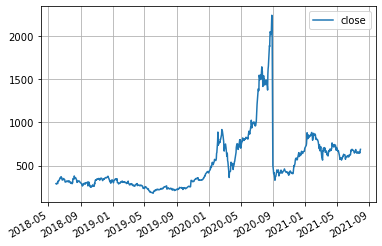

In [119]:
stock_data[['close']].plot(grid=True)
plt.show()

In [120]:
stock_data=stock_data.drop(['close'], axis=1)

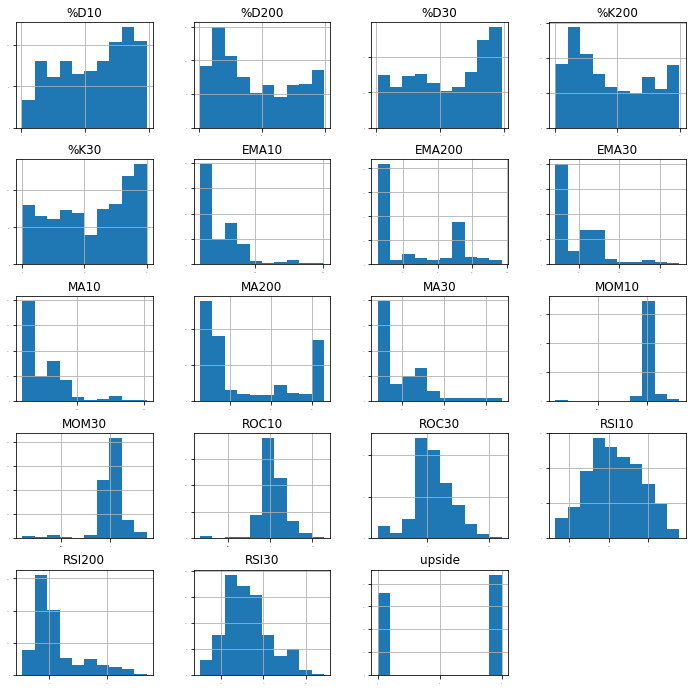

In [121]:
# histograms to understand how data is distributed
stock_data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

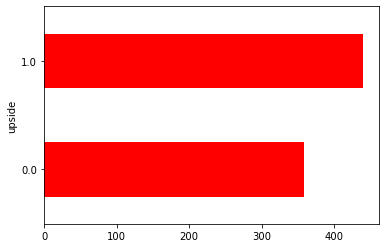

In [122]:
fig = plt.figure()
plot = stock_data.groupby(['upside']).size().plot(kind='barh', color='red')
plt.show()

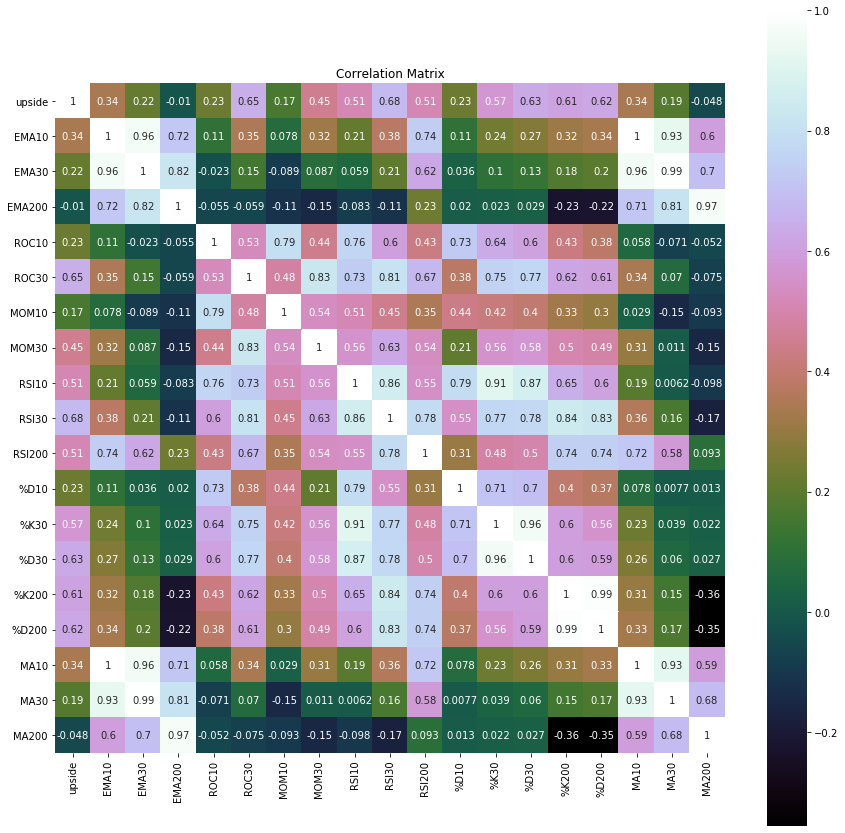

In [123]:
# correlation
correlation = stock_data.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

# Model training and evaluation

In [29]:
# Construct training start and end dates
training_start = stock_data.index.min().strftime(format= '%Y-%m-%d')
training_end = '2020-06-30'

# Construct testing start and end dates
testing_start =  '2020-07-01'
testing_end = stock_data.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2018-05-30
Training End: 2020-06-30
Testing Start: 2020-07-01
Testing End: 2021-07-30


In [140]:
# split out validation dataset for the end
y_train = stock_data["upside"][training_start:training_end]
X_train = stock_data.loc[:, stock_data.columns != 'upside'][training_start:training_end]

y_test = stock_data["upside"][testing_start:testing_end]
X_test = stock_data.loc[:, stock_data.columns != 'upside'][testing_start:testing_end]

In [141]:
# evaluation metrics for classification
num_folds = 5
seed = 7
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring = 'roc_auc'

## Models

In [142]:
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))

#Neural Network
models.append(('NN', MLPClassifier()))

#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))

# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

In [143]:
models

[('LR', LogisticRegression(n_jobs=-1)),
 ('KNN', KNeighborsClassifier()),
 ('CART', DecisionTreeClassifier()),
 ('NN', MLPClassifier()),
 ('AB', AdaBoostClassifier()),
 ('GBM', GradientBoostingClassifier()),
 ('RF', RandomForestClassifier(n_jobs=-1))]

In [144]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.973351 (0.011134)
KNN: 0.956244 (0.019653)
CART: 0.935346 (0.018513)
NN: 0.910584 (0.041204)
AB: 0.967691 (0.004579)
GBM: 0.950548 (0.020378)
RF: 0.952435 (0.018127)


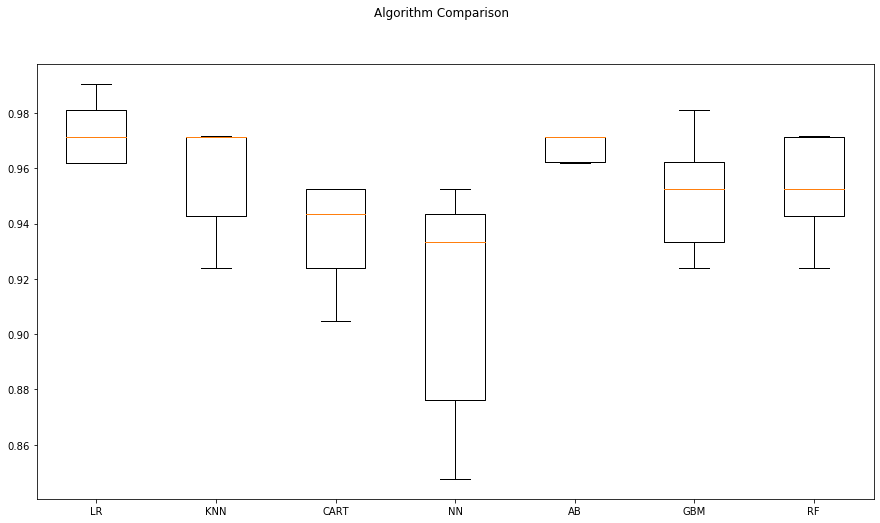

In [145]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

## Hyper Parameter Tuning with Grid Search

In [146]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,40,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.908805 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}
#12 0.868841 (0.067408) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#3 0.887907 (0.034484) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 40}
#10 0.874591 (0.064818) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#2 0.893621 (0.040264) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#4 0.884097 (0.057407) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 40}
#5 0.884061 (0.066577) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#10 0.874591 (0.061072) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#9 0.874609 (0.072430) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 40}
#6 0.880305 (0.060805) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#7 0.880288 (0.051498) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#8 0.876496 (0.066084) with:

## Fit the model and Run the trained model on the test dataset

In [147]:
# Setup the model based on the parameters suggested by Grid Search
model = RandomForestClassifier(criterion='entropy', n_estimators=80,max_depth=10) 
model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=80)

In [148]:
# Accuracy metrics on the test set
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.8681318681318682
[[107  23]
 [ 13 130]]
              precision    recall  f1-score   support

         0.0       0.89      0.82      0.86       130
         1.0       0.85      0.91      0.88       143

    accuracy                           0.87       273
   macro avg       0.87      0.87      0.87       273
weighted avg       0.87      0.87      0.87       273



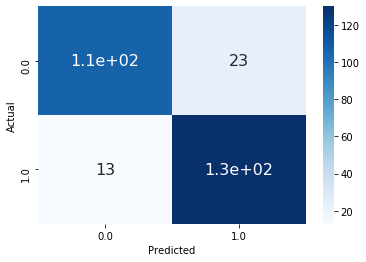

In [149]:
df_cm = pd.DataFrame(confusion_matrix(y_test, predictions), columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}) # font size

## Feature importance

Text(0.5, 0, 'Variable Importance')

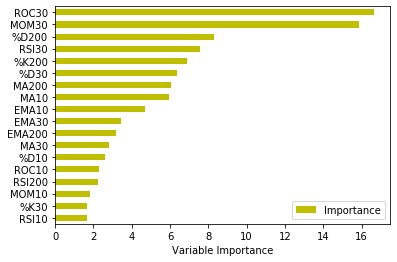

In [150]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X_train.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='y' )
plt.xlabel('Variable Importance')